# import packages

In [2]:
from itertools import permutations, product

import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, auc, confusion_matrix, balanced_accuracy_score, precision_recall_curve, auc, roc_curve, roc_auc_score, f1_score, recall_score, precision_score
from sklearn.inspection import permutation_importance
from sklearn import preprocessing

from sklearn.neural_network import MLPClassifier
from collections import Counter
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier

import numpy as np
from numpy import mean,std
from sklearn.model_selection import GridSearchCV

import pickle

from ctgan import CTGANSynthesizer
from mlxtend.classifier import StackingCVClassifier

from os import path
import tqdm
import matplotlib.pyplot as plt

from warnings import simplefilter
from collections import OrderedDict
from sklearn.svm import SVC

if (os.path.abspath('').split('/')[-1] == 'project'):
    %cd utils
elif (os.path.abspath('').split('/')[-1] == 'train_and_vis'):
    %cd ../utils

import query_utils
import model_utils
import validation_utils
import data_utils

if (os.path.abspath('').split('/')[-1] == 'utils'):
    %cd ..


simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

/Users/benjaminli/Documents/coding/scires/project/utils
/Users/benjaminli/Documents/coding/scires/project


### Synthetic Data creation
Performed with CTGANSynthesizer

In [2]:
isZoonotic = df.loc[df['isZoonotic']==1][:1200]
isZoonotic = isZoonotic.loc[:, isZoonotic.columns != 'isZoonotic']
print(isZoonotic)

posGanModel = CTGANSynthesizer(batch_size=60, epochs=10, verbose=True)
posGanModel.fit(isZoonotic)

# check if current model is better than pickled model
posGanModel.save('models/curr_models/posGanModel.pkl')

notZoonotic = df.loc[df['isZoonotic']==0][:3000]
notZoonotic = isZoonotic.loc[:, isZoonotic.columns != 'isZoonotic']
print(notZoonotic)

negGanModel = CTGANSynthesizer(batch_size=60, epochs=10, verbose=True)
negGanModel.fit(notZoonotic)
negGanModel.save('models/curr_models/negGanModel.pkl')

NameError: name 'df' is not defined

# Dataset retrieval
Workings of the function is packaged into data_utils (for readability). Data is generated within "process_data.ipynb".

In [3]:
dataset = data_utils.retrieveMerged(dir='data/')
# datasets = data_utils.retrieveAllDatasets()

working directory: /Users/benjaminli/Documents/coding/scires/project


## Keep track of scores of each model

In [11]:
# modelScores = {}
import json
modelScores = pickle.load(open('score_df.pkl', 'rb'))
modelScores = modelScores.T.to_dict()
modelScores

{'mlp_f1_4': {'fit_time': 9.182259464263916,
  'score_time': 0.38588614463806153,
  'test_recall': 0.8072016979783971,
  'test_f1': 0.6601338755726636,
  'test_accuracy': 0.8749357534170772,
  'test_precision': 0.5686347080784393,
  'test_roc_auc': 0.9236435213170576,
  'test_neg_brier_score': -0.09125115690858958,
  'total': 2.299727937959529},
 'mlp_f3_3': {'fit_time': 12.69257574081421,
  'score_time': 0.34751105308532715,
  'test_recall': 0.8383453116462825,
  'test_f1': 0.6473697885556842,
  'test_accuracy': 0.8494335011897516,
  'test_precision': 0.5495825398084325,
  'test_roc_auc': 0.9188979100863088,
  'test_neg_brier_score': -0.10668787556757205,
  'total': 2.2979251347207033},
 'mlp_f2_4': {'fit_time': 11.08979058265686,
  'score_time': 0.36149845123291013,
  'test_recall': 0.7766843189173287,
  'test_f1': 0.6699328776782045,
  'test_accuracy': 0.8882084223341267,
  'test_precision': 0.6028925092633572,
  'test_roc_auc': 0.9247547799273411,
  'test_neg_brier_score': -0.08142

# TODO

### Generate & validate performance of KNN (baseline) on dataset

In [4]:
print(dataset.keys())

dict_keys(['f1-3', 'f2-3', 'f3-3', 'f1-4', 'f2-4', 'f3-4', 'f1-5', 'f2-5', 'f3-5', 'f1-6', 'f2-6', 'f3-6'])


In [14]:
kmer = 4

features = ['f1', 'f2', 'f3']
for kmer in range(3, 7):
    for feature in features:
        ds = dataset[f'{feature}-{kmer}']

        X, y = ds['X'], ds['y']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        knntest = BalancedBaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors = 1, n_jobs = -1), n_estimators = 1, n_jobs = -1)

        # knntest = KNeighborsClassifier(n_neighbors = 1, n_jobs = -1)
        knntest.fit(X_train, y_train)
        # print(knntest.score(X_test, y_test))
        x = cross_validate(knntest, X, y, cv=5, scoring=['recall', 'f1', 'accuracy', 'precision', 'roc_auc', 'neg_brier_score'])
        
        name = f'knn_{feature}_{kmer}'
        
        if (name not in modelScores):
            modelScores[name] = {}
            for k, v in x.items():
                print(k, v.mean())
                modelScores[name][k]=v.mean()
        else:
            for k, v in x.items():
                print(k, v.mean())
            print('already in modelScores')

fit_time 0.006434345245361328
score_time 0.23126916885375975
test_recall 0.8065397385785735
test_f1 0.601296422615953
test_accuracy 0.8332461512921254
test_precision 0.48886637902036434
test_roc_auc 0.8221471395149335
test_neg_brier_score -0.1667538487078745
fit_time 0.006704187393188477
score_time 0.07589864730834961
test_recall 0.8065502458706343
test_f1 0.5710774429523003
test_accuracy 0.8175344806596204
test_precision 0.4473588072765174
test_roc_auc 0.8129614190277772
test_neg_brier_score -0.1824655193403796
fit_time 0.006073999404907227
score_time 0.03609743118286133
test_recall 0.8169524650107174
test_f1 0.6050472649993741
test_accuracy 0.8296698577831887
test_precision 0.4922435812769397
test_roc_auc 0.8243815709753642
test_neg_brier_score -0.17033014221681148
fit_time 0.02127671241760254
score_time 0.34290475845336915
test_recall 0.8065292312865127
test_f1 0.5827334292475597
test_accuracy 0.820355265342261
test_precision 0.4651860242243905
test_roc_auc 0.8146019849332949
test_n

In [17]:
print(modelScores)

{'knn_f1_4': {'fit_time': 0.556103515625, 'score_time': 2.1676071643829347, 'test_recall': 0.8967847686294288, 'test_f1': 0.5506206040204477, 'test_accuracy': 0.7598422223451939, 'test_precision': 0.4068609142945686, 'test_roc_auc': 0.8166917789212086, 'test_neg_brier_score': -0.24015777765480606}, 'knn_f2_4': {'fit_time': 0.5469307899475098, 'score_time': 0.5283036708831788, 'test_recall': 0.7209095112007733, 'test_f1': 0.49014203521664257, 'test_accuracy': 0.7846974710862709, 'test_precision': 0.37431163097253817, 'test_roc_auc': 0.7581982888970294, 'test_neg_brier_score': -0.2153025289137292}, 'knn_f3_4': {'fit_time': 0.5275906562805176, 'score_time': 0.5401241779327393, 'test_recall': 0.8695246501071743, 'test_f1': 0.5344595291629525, 'test_accuracy': 0.7597513806651541, 'test_precision': 0.39288153362735134, 'test_roc_auc': 0.8053181863634385, 'test_neg_brier_score': -0.24024861933484587}}


### Evaluate & validate performance of random forest (baseline) on dataset

In [15]:
kmer = 4

features = ['f1', 'f2', 'f3']
for kmer in range(3, 7):
    for feature in features:
        ds = dataset[f'{feature}-{kmer}']

        X, y = ds['X'], ds['y']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # randforest = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_features="sqrt"), n_estimators=1, n_jobs=-1)
        randforest = BalancedRandomForestClassifier(max_features="sqrt", n_jobs=-1)

        # randforest.fit(X_train, y_train)
        randforest.fit(X_train, y_train)
        x = cross_validate(randforest, X, y, cv=5, scoring=['recall', 'f1', 'accuracy', 'precision', 'roc_auc', 'neg_brier_score'])
        name = f'rf_{feature}_{kmer}'
        if (name not in modelScores):
            modelScores[name] = {}
            for k, v in x.items():
                print(k, v.mean())
                modelScores[name][k]=v.mean()
        else:
            for k, v in x.items():
                print(k, v.mean())
                modelScores[name][k]=v.mean()
            print('already in modelScores')


fit_time 0.673237657546997
score_time 0.06305813789367676
test_recall 0.8033287101248267
test_f1 0.6376446981126623
test_accuracy 0.8496201427701843
test_precision 0.557841501561644
test_roc_auc 0.9113908529679753
test_neg_brier_score -0.1036142534713076
fit_time 0.30217394828796384
score_time 0.038896369934082034
test_recall 0.7734417685873997
test_f1 0.6213791860135606
test_accuracy 0.8658125394278124
test_precision 0.5325331554110591
test_roc_auc 0.9063302693213835
test_neg_brier_score -0.1044856117846273
fit_time 0.28589487075805664
score_time 0.03607010841369629
test_recall 0.8026772580170638
test_f1 0.635436790839013
test_accuracy 0.8511267777101434
test_precision 0.5558658633147152
test_roc_auc 0.9113416202038491
test_neg_brier_score -0.10388738292291518
fit_time 0.3828004837036133
score_time 0.04037809371948242
test_recall 0.8247236582188038
test_f1 0.6207048310771551
test_accuracy 0.83861386752255
test_precision 0.5229388200064958
test_roc_auc 0.910494420772485
test_neg_brier_

### XGB classifier

In [16]:
kmer = 4

features = ['f1', 'f2', 'f3']
for kmer in range(3, 7):
    for feature in features:
        ds = dataset[f'{feature}-{kmer}']

        X, y = ds['X'], ds['y']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # randforest = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_features="sqrt"), n_estimators=1, n_jobs=-1)
        xgb1 = BalancedBaggingClassifier(base_estimator=XGBClassifier(
        learning_rate =0.1,
        n_estimators=300,
        max_depth=9,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        #  scale_pos_weight=1,
        seed=42,
        n_jobs=-1,
        scale_pos_weight=6,
        ), n_estimators=1, n_jobs=-1)
        xgb1.fit(X_train, y_train)

        # randforest.fit(X_train, y_train)
        x = cross_validate(xgb1, X, y, cv=5, scoring=['recall', 'f1', 'accuracy', 'precision', 'roc_auc', 'neg_brier_score'])
        name = f'xgb_{feature}_{kmer}'
        if (name not in modelScores):
            modelScores[name] = {}
            for k, v in x.items():
                print(k, v.mean())
                modelScores[name][k]=v.mean()
        else:
            for k, v in x.items():
                print(k, v.mean())
                modelScores[name][k]=v.mean()
            print('already in modelScores')

fit_time 3.2481399536132813
score_time 0.015207624435424805
test_recall 0.8098222166183332
test_f1 0.5993580116185406
test_accuracy 0.8287332411045322
test_precision 0.49247938747250075
test_roc_auc 0.8983555937573016
test_neg_brier_score -0.13648852807028594
fit_time 3.682933235168457
score_time 0.01545543670654297
test_recall 0.7974509309460764
test_f1 0.5985745962711088
test_accuracy 0.8438875546455649
test_precision 0.48785963453151826
test_roc_auc 0.8971440087235623
test_neg_brier_score -0.12304992852125171
fit_time 3.7060344219207764
score_time 0.014565849304199218
test_recall 0.8137288278064977
test_f1 0.6115900124135841
test_accuracy 0.834283083393282
test_precision 0.5106685846240002
test_roc_auc 0.9068828343370023
test_neg_brier_score -0.1307657871800653
fit_time 3.781730365753174
score_time 0.01956338882446289
test_recall 0.8156201403774219
test_f1 0.6104394394548548
test_accuracy 0.8383293010901444
test_precision 0.5084032815414197
test_roc_auc 0.9124100464192155
test_neg_b

In [10]:
print(modelScores.keys())

dict_keys(['rf_f1_3', 'rf_f2_3', 'rf_f3_3', 'rf_f1_4', 'rf_f2_4', 'rf_f3_4', 'rf_f1_5', 'rf_f2_5', 'rf_f3_5', 'rf_f1_6', 'rf_f2_6', 'rf_f3_6', 'xgb_f1_3', 'xgb_f2_3', 'xgb_f3_3', 'xgb_f1_4', 'xgb_f2_4', 'xgb_f3_4', 'xgb_f1_5', 'xgb_f2_5', 'xgb_f3_5', 'xgb_f1_6', 'xgb_f2_6', 'xgb_f3_6'])


In [17]:
# ds = datasets['merged']['lengthdivdataset-4']
features = ['f1', 'f2', 'f3']
for kmer in range(3, 7):
    for feature in features:
        ds = dataset[f'{feature}-{kmer}']

        X, y = ds['X'], ds['y']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # randforest = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_features="sqrt"), n_estimators=1, n_jobs=-1)
        mlp = BalancedBaggingClassifier(base_estimator=MLPClassifier(alpha=0.6, hidden_layer_sizes=(100, 180, 180, 200, 200),
              max_iter=550, random_state=42, solver='adam', activation='relu'), n_estimators=5, n_jobs=-1)
        mlp.fit(X_train, y_train)

        # randforest.fit(X_train, y_train)
        x = cross_validate(mlp, X, y, cv=5, scoring=['recall', 'f1', 'accuracy', 'precision', 'roc_auc', 'neg_brier_score'])
        name = f'mlp_{feature}_{kmer}'
        if (name not in modelScores):
            modelScores[name] = {}
            for k, v in x.items():
                print(k, v.mean())
                modelScores[name][k]=v.mean()
        else:
            for k, v in x.items():
                print(k, v.mean())
                modelScores[name][k]=v.mean()
            print('already in modelScores')

fit_time 5.641985559463501
score_time 0.3429579257965088
test_recall 0.7909805404951037
test_f1 0.6129231538456255
test_accuracy 0.8570628299485363
test_precision 0.5071047997117664
test_roc_auc 0.915887930020903
test_neg_brier_score -0.10401978874103301
fit_time 12.340601348876953
score_time 0.29123740196228026
test_recall 0.7689047198755936
test_f1 0.6527537339157734
test_accuracy 0.8850068728902662
test_precision 0.5774773243160104
test_roc_auc 0.9211042043255068
test_neg_brier_score -0.08127809550056461
fit_time 12.69257574081421
score_time 0.34751105308532715
test_recall 0.8383453116462825
test_f1 0.6473697885556842
test_accuracy 0.8494335011897516
test_precision 0.5495825398084325
test_roc_auc 0.9188979100863088
test_neg_brier_score -0.10668787556757205
fit_time 9.182259464263916
score_time 0.38588614463806153
test_recall 0.8072016979783971
test_f1 0.6601338755726636
test_accuracy 0.8749357534170772
test_precision 0.5686347080784393
test_roc_auc 0.9236435213170576
test_neg_brier_

/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


fit_time 32.21785717010498
score_time 0.711247444152832
test_recall 0.7974656411549615
test_f1 0.6316306377024214
test_accuracy 0.8657188644789995
test_precision 0.5371231872472746
test_roc_auc 0.9202469133832045
test_neg_brier_score -0.09866557396511037
fit_time 24.688657188415526
score_time 0.6551656723022461
test_recall 0.8007102929433026
test_f1 0.6163852010676341
test_accuracy 0.84877941453157
test_precision 0.5110844203436183
test_roc_auc 0.9071307607457563
test_neg_brier_score -0.11622677904897338


In [ ]:
fit_time 71.89677076339721
score_time 0.10850300788879394
test_recall 0.8584950773558369
test_f1 0.6911281484361098
test_accuracy 0.8864734363076601
test_precision 0.5796959595204415
test_roc_auc 0.9540192015137766
test_neg_brier_score -0.07964541647825815

In [20]:
print(len(modelScores.keys()))
# print(modelScores.keys())
# print(modelScores['mlp_balanced_normalized_4'])
# print(modelScores['mlp_balanced_normalized_4'])

48


In [21]:
features = ['f1', 'f2', 'f3']
for kmer in range(3, 7):
    for feature in features:
        ds = dataset[f'{feature}-{kmer}']

        X, y = ds['X'], ds['y']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # randforest = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_features="sqrt"), n_estimators=1, n_jobs=-1)
        temp_svm = BalancedBaggingClassifier(base_estimator=SVC(kernel='rbf', C=2, gamma=0.6, probability=True, random_state=42), n_estimators=10, n_jobs=-1)
        temp_svm.fit(X_train, y_train)

        # randforest.fit(X_train, y_train)
        x = cross_validate(temp_svm, X, y, cv=5, scoring=['recall', 'f1', 'accuracy', 'precision', 'roc_auc', 'neg_brier_score'])
        name = f'svm_{feature}_{kmer}'
        if (name not in modelScores):
            modelScores[name] = {}
            for k, v in x.items():
                print(k, v.mean())
                modelScores[name][k]=v.mean()
        else:
            for k, v in x.items():
                print(k, v.mean())
                modelScores[name][k]=v.mean()
            print('already in modelScores')

/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


fit_time 1.9005918025970459
score_time 1.832925271987915
test_recall 0.0012965998402891608
test_f1 0.002584820962522184
test_accuracy 0.8550861380111782
test_precision 0.4
test_roc_auc 0.510706523502875
test_neg_brier_score -0.14527397592299335
fit_time 1.0388792037963868
score_time 1.184439754486084
test_recall 0.7682637750598916
test_f1 0.6470785392118301
test_accuracy 0.8794546843008135
test_precision 0.5694617314417644
test_roc_auc 0.9059787336109665
test_neg_brier_score -0.08563907097963931
fit_time 1.820357084274292
score_time 1.633793306350708
test_recall 0.6223111839616695
test_f1 0.6622677588722691
test_accuracy 0.9047616623319129
test_precision 0.7670728169863373
test_roc_auc 0.8690880648935909
test_neg_brier_score -0.07928686951563617


/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


fit_time 6.530042266845703
score_time 3.4427698135375975
test_recall 0.0012965998402891608
test_f1 0.002584820962522184
test_accuracy 0.8550861380111782
test_precision 0.4
test_roc_auc 0.5082480131965573
test_neg_brier_score -0.1457355230836727
fit_time 6.441674995422363
score_time 3.110650157928467
test_recall 0.7195666792754171
test_f1 0.680627734884343
test_accuracy 0.9109778982900781
test_precision 0.6755043001874332
test_roc_auc 0.9195314656792288
test_neg_brier_score -0.06779188285595661
fit_time 4.718837118148803
score_time 2.7102776527404786
test_recall 0.7358361703021898
test_f1 0.6401249173404641
test_accuracy 0.877006253112722
test_precision 0.5891997818295154
test_roc_auc 0.8913670041328989
test_neg_brier_score -0.08740740861294846


/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


fit_time 31.155922889709473
score_time 12.689632606506347
test_recall 0.0012965998402891608
test_f1 0.002584820962522184
test_accuracy 0.8550861380111782
test_precision 0.4
test_roc_auc 0.5064696334864541
test_neg_brier_score -0.14603576232779042
fit_time 31.866920471191406
score_time 12.23724298477173
test_recall 0.3319232547387887
test_f1 0.44129358607854174
test_accuracy 0.8936664047368712
test_precision 0.8403621359124871
test_roc_auc 0.875871270787408
test_neg_brier_score -0.0972674594534371
fit_time 25.571607255935668
score_time 10.544783449172973
test_recall 0.7461669398562603
test_f1 0.5291742991048717
test_accuracy 0.8215867190526257
test_precision 0.4163185110362675
test_roc_auc 0.8431971153418008
test_neg_brier_score -0.13201217769586973


/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


fit_time 109.18032379150391
score_time 53.78303756713867
test_recall 0.0012965998402891608
test_f1 0.002584820962522184
test_accuracy 0.8550861380111782
test_precision 0.4
test_roc_auc 0.50618518657562
test_neg_brier_score -0.146554394177546
fit_time 101.62899775505066
score_time 47.86398730278015
test_recall 0.1095553313999916
test_f1 0.18371642419827017
test_accuracy 0.8666605279176581
test_precision 0.8303641312939307
test_roc_auc 0.8119340753412974
test_neg_brier_score -0.12238631828837598
fit_time 109.11372156143189
score_time 50.53300194740295
test_recall 0.8898226369100156
test_f1 0.3489018698900065
test_accuracy 0.49279548447789273
test_precision 0.21956569655117636
test_roc_auc 0.7556959434635748
test_neg_brier_score -0.2238242948240226


In [179]:
ds = dataset['f2-4']
X, y = ds['X'], ds['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


xgb1 = XGBClassifier(
        learning_rate =0.09,
        n_estimators=200,
        max_depth=9,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        #  scale_pos_weight=1,
        seed=42,
        n_jobs=-1,
        scale_pos_weight=6,
        )

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.3)

xgb1.fit(X_train, y_train, eval_metric='aucpr', eval_set=[(X_validation, y_validation)], early_stopping_rounds=15, verbose=10)

# xgb1.fit(X_train, y_train)

# x = cross_validate(xgb1, X, y, cv=5, scoring=['recall', 'f1', 'accuracy', 'precision', 'roc_auc', 'neg_brier_score'])

# for k, v in x.items():
#         print(k, v.mean())
        # modelScores[name][k]=v.mean()

# X_test = X_test[xgb1.get_booster().feature_names]

# print(accuracy_score(xgb1.predict(X_test), y_test))
# print(recall_score(xgb1.predict(X_test), y_test))
# print(f1_score(xgb1.predict(X_test), y_test))

[0]	validation_0-aucpr:0.60215
[10]	validation_0-aucpr:0.79226
[20]	validation_0-aucpr:0.82126
[30]	validation_0-aucpr:0.83316
[40]	validation_0-aucpr:0.84168
[50]	validation_0-aucpr:0.84784
[60]	validation_0-aucpr:0.85343
[70]	validation_0-aucpr:0.85694
[80]	validation_0-aucpr:0.85838
[90]	validation_0-aucpr:0.86029
[100]	validation_0-aucpr:0.86255
[110]	validation_0-aucpr:0.86355
[120]	validation_0-aucpr:0.86534
[130]	validation_0-aucpr:0.86587
[140]	validation_0-aucpr:0.86640
[150]	validation_0-aucpr:0.86598
[160]	validation_0-aucpr:0.86754
[170]	validation_0-aucpr:0.86833
[180]	validation_0-aucpr:0.86805
[190]	validation_0-aucpr:0.86813
[199]	validation_0-aucpr:0.86812


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.09, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=9, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [1]:
ds = dataset[f'f2-4']

X, y = ds['X'], ds['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# randforest = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_features="sqrt"), n_estimators=1, n_jobs=-1)
knn = BalancedBaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors = 1, n_jobs = -1), n_estimators = 1, n_jobs = -1)

# randforest.fit(X_train, y_train)
knn.fit(X_train, y_train)

precision, recall, thresholds = precision_recall_curve(y_test, knn.predict_proba(X_test)[:,1])
area = auc(recall, precision)


print('Area Under Curve: %.2f' % area)

x = cross_validate(knn, X, y, cv=10, scoring=['recall', 'f1', 'accuracy', 'precision', 'roc_auc', 'neg_brier_score', 'average_precision'])

for k, v in x.items():
    print(k, v.mean())
        # modelScores[name][k]=v.mean()

x = cross_validate(xgb1, X, y, cv=10, scoring=['recall', 'f1', 'accuracy', 'precision', 'roc_auc', 'neg_brier_score', 'average_precision'])

for k, v in x.items():
    print(k, v.mean())
# print(accuracy_score(knn.predict(X_test), y_test))
# print(recall_score(knn.predict(X_test), y_test))


# print(accuracy_score(xgb1.predict(X_test), y_test))
# print(recall_score(xgb1.predict(X_test), y_test))
# print(f1_score(xgb1.predict(X_test), y_test))
# pickle.dump(xgb1, open('models/curr_models/xgBoost.pkl', 'wb'))

NameError: name 'dataset' is not defined

## Order models by performance

In [ ]:
score_df = pd.DataFrame(modelScores).T

# select model with best overall scores, precision doesn't really matter, excluding accuracy just because
score_df['total'] = score_df.apply(lambda x: x[['test_f1', 'test_recall', 'test_roc_auc', 'test_neg_brier_score']].sum(), axis=1)
score_df['name'] = score_df.apply(lambda x: x.name.split("_")[0], axis=1)
score_df['feature'] = score_df.apply(lambda x: x.name.split("_")[1], axis=1)
score_df['kmer'] = score_df.apply(lambda x: x.name.split("_")[2], axis=1)
# sort based on total column
score_df = score_df.sort_values(by='test_f1', ascending=False)
# print(len(score_df))

# for each k-mer value, create a plot with the AUC score of each model and each feature and put it into one graph


# for kmer in modelKmers:
#     for name in modelNames:
#         for feature in modelFeatures:
#             df = score_df[score_df.index.str.contains(f'{name}_{feature}_{kmer}')]
#             df.plot.bar(y=['test_f1', 'test_recall', 'test_roc_auc', 'test_neg_brier_score', 'test_accuracy'], figsize=(20, 10))
#             plt.title(f'{name} {feature} {kmer}')
#     plt.show()

# retrieve all model names
modelNames = score_df['name'].unique()

for kmer in range(3, 7):
    # for feature in features:

    for modelName in modelNames:
        # retrieve models that match the current name and k-mer
        df = score_df[score_df['name'] == modelName]
        df = df[df['kmer'] == str(kmer)]
        # rename all indices to the name of the model
        print(df)
        df.index = df.apply(lambda x: x.name.split("_")[0], axis=1)
        
        # plot the auc for 
        df.plot.bar(y=['test_roc_auc', 'test_accuracy'], figsize=(20, 10), rot=0, )
        plt.title(f'kmer = {kmer}, feature = {feature}')
    plt.show()

# xg_boost = score_df[score_df.index.str.contains(f'{name}_{feature}_{kmer}')]
# # mlp = score_df[score_df.index.str.contains('mlp')]
# # svm = score_df[score_df.index.str.contains('svm')]
# xg_boost.plot.bar(y=['test_f1', 'test_recall', 'test_roc_auc', 'test_neg_brier_score', 'test_accuracy'], figsize=(20, 10))

# xg_boost.plot.bar(y=['test_f1', 'test_recall', 'test_roc_auc', 'test_neg_brier_score', 'test_accuracy'], figsize=(20, 10))
# pickle.dump(score_df, open('score_df.pkl', 'wb'))

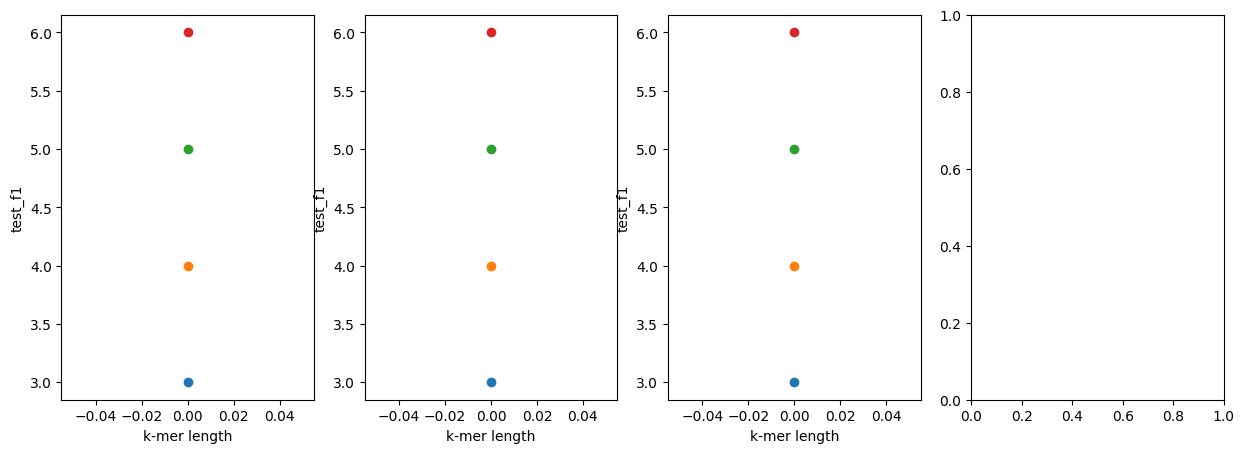

In [68]:
metric = 'test_f1'

# Create a figure and subplots for each feature
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

# Loop through each k-mer length
for length in range(3, 7):
    # Loop through each feature
    for i, feature in enumerate(['knn_f1', 'knn_f2', 'knn_f3']):
        # Extract the data for the current length and feature
        data = [modelScores[model][metric] for model in modelScores]
        # print(data)
        # Plot the data on the corresponding subplot
        axs[i].plot(length, 'o-')
        axs[i].set_xlabel('k-mer length')
        axs[i].set_ylabel(metric)

# Show the plot
plt.show()

## Dump models into pickle - TODO

### Grid-Searched version of the Gradient Boosting classifier

In [ ]:
ds = datasets['merged'][f'normalized-{kmer}']

X_train, y_train, X_test, y_test = ds['X_train'], ds['y_train'], ds['X_test'], ds['y_test']

"""
{'n_estimators': 120, 'max_features': 2, 'max_depth': 6, 'random_state': 0, 'min_sample_split': 50, 'subsample': 0.8, 'learning_rate': 0.3}
"""

parameters={
   'n_estimators': 120, 'max_features': 2, 'max_depth': 6, 'random_state': 42, 'min_sample_split': 50, 'subsample': 0.8, 'learning_rate': 0.3
}

param_test1 = {'n_estimators':range(100,140,10), 'learning_rate':[0.1,0.15,0.2], 'subsample':[0.8,0.85,0.9], 'max_depth':range(6,9,1), 'min_samples_split':range(10,40,10), 'max_features':range(2, 5)}

gradBoost = GridSearchCV(estimator = GradientBoostingClassifier(
    n_estimators=parameters['n_estimators'], max_features=parameters['max_features'], random_state=parameters['random_state']), 
param_grid = param_test1, scoring='roc_auc',n_jobs=-1, cv=5, verbose=10)

# parameters['learning_rate']=learning_rate
gradBoost.fit(X_train, y_train)

### Load available models

In [ ]:
from itertools import combinations_with_replacement
def hidden_layers_generator(hidden_layers, max_neurons):
  hd_sizes = []
  comb = combinations_with_replacement(np.arange(100,max_neurons+10,20), hidden_layers)
  hd_sizes.append(list(comb))
  return hd_sizes


# ds = datasets['merged'][f'normalized-{kmer}']

# X_train, y_train, X_test, y_test = ds['X_train'], ds['y_train'], ds['X_test'], ds['y_test']

X = pd.concat([X_train, X_test])
y = np.concatenate([ds['y_train'], ds['y_test']], axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print(l)
hlg = hidden_layers_generator(hidden_layers=5, max_neurons=200)
print(hlg)

mlp_gs = MLPClassifier(max_iter=350, random_state=42, solver='adam')

parameter_space = {
    'hidden_layer_sizes': hlg[0],
    'activation': ['relu'],
    'alpha': [0.05, 0.1, 0.2],
}
clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5, verbose=10, scoring='recall')
clf.fit(X_train, y_train) # X is train samples and y is the corresponding labels

### Creation of the ensemble model

### Select the best current model

In [85]:


score_df = score_df.sort_values(by=['test_roc_auc'], ascending=False)
score_df

,fit_time,score_time,test_recall,test_f1,test_accuracy,test_precision,test_roc_auc,test_neg_brier_score,total,name,feature,kmer
mlp_f2_5,15.924036,0.425549,0.772120,0.644200,0.877951,0.576176,0.925820,-0.089756,2.252384,mlp,f2,5
mlp_f2_4,11.089791,0.361498,0.776684,0.669933,0.888208,0.602893,0.924755,-0.081424,2.289948,mlp,f2,4
mlp_f1_4,9.182259,0.385886,0.807202,0.660134,0.874936,0.568635,0.923644,-0.091251,2.299728,mlp,f1,4
mlp_f1_6,51.713082,0.975803,0.802646,0.636191,0.865438,0.537411,0.922410,-0.094534,2.266713,mlp,f1,6
mlp_f1_5,22.543625,0.448890,0.798760,0.635674,0.864683,0.545367,0.921641,-0.091369,2.264706,mlp,f1,5
mlp_f2_3,12.340601,0.291237,0.768905,0.652754,0.885007,0.577477,0.921104,-0.081278,2.261485,mlp,f2,3
mlp_f2_6,32.217857,0.711247,0.797466,0.631631,0.865719,0.537123,0.920247,-0.098666,2.250678,mlp,f2,6
svm_f2_4,6.441675,3.110650,0.719567,0.680628,0.910978,0.675504,0.919531,-0.067792,2.251934,svm,f2,4
mlp_f3_3,12.692576,0.347511,0.838345,0.647370,0.849434,0.549583,0.918898,-0.106688,2.297925,mlp,f3,3
mlp_f1_3,5.641986,0.342958,0.790981,0.612923,0.857063,0.507105,0.915888,-0.104020,2.215772,mlp,f1,3


In [139]:
# pretrained models
ds = dataset['f2-4']
X, y = ds['X'], ds['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# MLP: f2_4
mlp = BalancedBaggingClassifier(base_estimator=MLPClassifier(alpha=0.6, hidden_layer_sizes=(100, 180, 180, 200, 200),
              max_iter=550, random_state=42, solver='adam', activation='relu'), n_estimators=5, n_jobs=-1)

mlp.fit(X_train, y_train)

# SVM: f2_4
# temp_svm = BalancedBaggingClassifier(base_estimator=SVC(kernel='rbf', C=2, gamma=0.6, probability=True, random_state=42), n_estimators=10, n_jobs=-1)

# temp_svm.fit(X_train, y_train)

# RF: f2_4
randforest = BalancedRandomForestClassifier(max_features="sqrt", n_jobs=-1)

randforest.fit(X_train, y_train)

# XGBoost: f2_4
xgb1 = BalancedBaggingClassifier(base_estimator=XGBClassifier(
        learning_rate =0.1,
        n_estimators=200,
        max_depth=9,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        #  scale_pos_weight=1,
        seed=42,
        n_jobs=-1,
        scale_pos_weight=6,
        ), n_estimators=1, n_jobs=-1)
xgb1.fit(X_train, y_train)
# xgb1 = pickle.load(open('models/curr_models/xgb1-test.pkl', 'rb'))


# xgb1.fit(X_train, y_train)

em = StackingCVClassifier(classifiers = [mlp, randforest, xgb1],
                            # shuffle = True,
                            use_probas = True,
                            cv = 5,
                            use_features_in_secondary=True,
                            meta_classifier = LogisticRegression(C = 5, random_state=42), n_jobs=-1, random_state=42, verbose=1, store_train_meta_features=True)
em.fit(X_train, y_train)
# x = cross_validate(em, X, y, cv=5, scoring=['recall', 'f1', 'accuracy', 'precision', 'roc_auc', 'neg_brier_score'], verbose=1, n_jobs=-1)
# name = 'ensemble_lengthdiv_4'
# if (name not in modelScores):
#     modelScores[name] = {}
#     for k, v in x.items():
#         print(k, v.mean())
#         modelScores[name][k]=v.mean()
# else:
#     print('already in modelScores')
# em.fit(X_train, y_train)

KeyboardInterrupt: 

In [115]:
print(accuracy_score(y_test, em.predict(X_test)))
print(recall_score(y_test, em.predict(X_test)))
print(f1_score(y_test, em.predict(X_test)))
# pickle.dump(em, open('models/curr_models/ensemble.pkl', 'wb'))
asdf = pickle.load(open('models/curr_models/xgb1-test.pkl', 'rb'))


# print(em.)


0.9388523047977423
0.7352941176470589
0.7758620689655173


In [116]:
print(accuracy_score(y_test, asdf.predict(X_test)))
print(recall_score(y_test, asdf.predict(X_test)))
print(f1_score(y_test, asdf.predict(X_test)))

print(accuracy_score(y_test, temp_svm.predict(X_test)))
print(recall_score(y_test, temp_svm.predict(X_test)))
print(f1_score(y_test, temp_svm.predict(X_test)))

0.967074317968015
0.7973856209150327
0.874551971326165
0.9285042333019755
0.7941176470588235
0.7617554858934168


In [127]:
# print(em.clfs_)
x = cross_val_score(em, X, y, cv=2, scoring='recall', verbose=1, n_jobs=-1)
# x = cross_validate(em.clfs_, X, y, cv=2, scoring=['recall', 'f1', 'accuracy', 'precision', 'roc_auc', 'neg_brier_score'], verbose=1, n_jobs=-1)
# name = 'ensemble_lengthdiv_4'
# if (name not in modelScores):
#     modelScores[name] = {}
#     for k, v in x.items():
#         print(k, v.mean())
#         modelScores[name][k]=v.mean()
# else:
#     print('already in modelScores')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Fitting 3 classifiers...
Fitting 3 classifiers...
Fitting classifier1: balancedbaggingclassifier (1/3)
Fitting classifier1: balancedbaggingclassifier (1/3)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier2: balancedbaggingclassifier (2/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier3: balancedbaggingclassifier (3/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier2: balancedbaggingclassifier (2/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier3: balancedbaggingclassifier (3/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.3s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.7s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  3.2min finished


In [128]:
print(x)

[0.77172503 0.71725032]


In [48]:
# dump em
pickle.dump(em, open('models/curr_models/em.pkl', 'wb'))